In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [35]:
# Load the dataset with specified column names
file_path = 'EVChargingStationUsage.csv'  # Update with your actual file path
column_names = ['Station Name', 'MAC Address', 'Org Name', 'Start Date', 'Start Time Zone', 
                'End Date', 'End Time Zone', 'Transaction Date', 'Total Duration', 
                'Charging Time', 'Energy (kWh)', 'GHG Savings (kg)', 'Gasoline Savings (gallons)', 
                'Port Type', 'Port Number', 'Plug Type', 'EVSE ID', 'Address 1', 'City', 
                'State/Province', 'Postal Code', 'Country', 'Latitude', 'Longitude', 'Currency', 
                'Fee', 'Ended By', 'Plug In Event Id', 'Driver Postal Code', 'User ID', 
                'County', 'System S/N', 'Model Number']
df = pd.read_csv(file_path, names=column_names, header=0)

C:\Users\krist\AppData\Local\Temp\ipykernel_7968\2759451925.py:10: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, names=column_names, header=0)


In [37]:
# Convert date column to datetime and extract hourly data
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce')
df = df.dropna(subset=['Transaction Date'])  # Drop rows where date is missing

# Extract hour and day information
df['Hour'] = df['Transaction Date'].dt.hour  # Extract hour
df['Day'] = df['Transaction Date'].dt.date   # Extract date as day


In [39]:
# Filter only relevant columns for prediction
df = df[['Station Name', 'Energy (kWh)', 'Hour', 'Day']]

# Resample data to hourly energy usage per station
hourly_data = df.groupby(['Station Name', 'Day', 'Hour']).agg({'Energy (kWh)': 'sum'}).reset_index()


In [41]:
# Baseline Model - Predicts the average hourly energy for a given day/hour combination
baseline_forecast = hourly_data.groupby(['Hour'])['Energy (kWh)'].transform('mean')
baseline_mse = mean_squared_error(hourly_data['Energy (kWh)'], baseline_forecast)
print(f"Baseline Model MSE: {baseline_mse}")

# Prepare data for machine learning
X = hourly_data[['Hour']]
y = hourly_data['Energy (kWh)']

Baseline Model MSE: 62.59751859736331


In [43]:
# Train-test split
train_size = int(0.7 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the prediction model
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
model_mse = mean_squared_error(y_test, y_pred)
print(f"Prediction Model MSE: {model_mse}")


Prediction Model MSE: 77.85683752271197


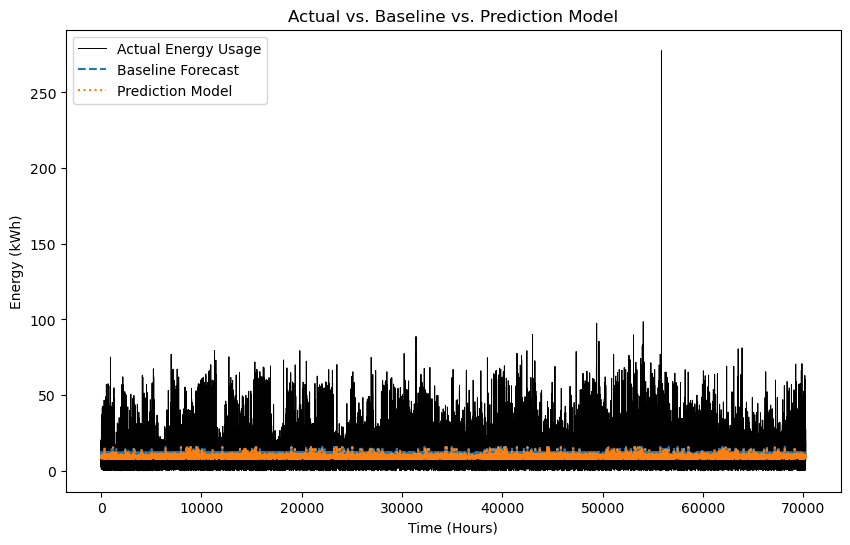

In [45]:
# Compare baseline and prediction model results
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Energy Usage', color='black', linewidth=0.7)
plt.plot(range(len(y_test)), baseline_forecast[train_size:], label='Baseline Forecast', linestyle='--')
plt.plot(range(len(y_test)), y_pred, label='Prediction Model', linestyle=':')
plt.xlabel('Time (Hours)')
plt.ylabel('Energy (kWh)')
plt.title('Actual vs. Baseline vs. Prediction Model')
plt.legend()
plt.show()